In [1]:
from torch.utils.data import Dataset
import pyedflib
import numpy as np
import pandas as pd
from scipy.signal import spectrogram, welch
from xgboost import XGBClassifier, plot_tree
from sklearn import metrics
from chb_utils import parse_summary_file, parse_summary_file_chb24
import os
import random
import hdbscan
import math
import yasa
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay,roc_auc_score, f1_score,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from scipy.integrate import simps

            
from sklearn.cluster import KMeans,SpectralClustering
from hdbscan import flat

In [2]:
class DataWindow:
    def __init__(self, record_id, record_file, start_index, end_index, label, channels):
        self.record_id = record_id
        self.record_file = record_file
        self.start_index = start_index
        self.end_index = end_index
        self.label = label
        self.channels = channels
        
    def get_data(self):
        with pyedflib.EdfReader(self.record_file) as f:
            labels = f.getSignalLabels()
            
            expected_channels = 23
            actual_channels   = f.signals_in_file
            
            data = []
            idxs = []
            for channel in self.channels:
                if channel in labels:
                    idxs.append(labels.index(channel))
            #if len(idxs) != expected_channels: 
            #    raise ValueError(f'{len(idxs)} channels found, expected {expected_channels}.')
            
            size = self.end_index - self.start_index
            data = np.zeros((expected_channels, size))
            for i,j in enumerate(idxs):
                data[i, :] = f.readSignal(j, self.start_index, size)
        return data

In [46]:
class ChbDataset(Dataset):
    def __init__(self, data_dir='./chb-mit-scalp-eeg-database-1.0.0/',
                 seizures_only=True,sample_rate=256,subject='chb01',mode='train',
                 window_length=5, preictal_length=300, sampler='all', which_features='welch',
                 multiclass=False, sliding=False): 
        ### other sampler option is "equal"
        'Initialization'
        self.pca_features = True if 'PCA' in which_features else False
        self.welch_features = True if 'welch' in which_features else False
        self.band_features = True if 'bands' in which_features else False
        
        self.sample_rate = sample_rate
        self.subject = subject
        self.data_dir = data_dir
        self.window_length = window_length
        self.preictal_length = preictal_length
        self.multiclass = multiclass
        self.sampler = sampler
        self.mode = mode
        self.record_type = 'RECORDS-WITH-SEIZURES' if seizures_only else 'RECORDS'
        self.records = None
        self.num_channels = 23
        self.sliding = sliding
        self.preictal = []
        self.ictal = []
        self.interictal = []
        self.windows = []
        self.channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
                               'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
                               'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']

        #self.bands = [0.5,3.5,6.5,9.5,12.5,15.5,18.5,21.5,24.5]
        self.bands = [0,4,8,13,30,60,90]

        random.seed(1000)
        self.get_records() 
        self.get_labeled_windows()
        self.get_windows_for_epoch()
        
    def get_records(self):
        with open(self.data_dir+self.record_type) as f:
            self.records = f.read().strip().splitlines()
            f.close()
            
        with open(self.data_dir+'RECORDS-WITH-SEIZURES') as f:
            self.labelled = f.read().strip().splitlines()
            f.close()
            
        #filter based on subject
        self.records = [record for record in self.records if self.subject in record]
        
        limit_file = None
        if self.mode == 'train':
            limit_file = 'TRAIN_RECORDS.txt'
        elif self.mode == 'test':
            limit_file = 'TEST_RECORDS.txt'
            
        if limit_file:
            with open(limit_file) as f:
                limit_records = set(f.read().strip().splitlines())
                records = set(self.records)
            self.records = list(records.intersection(limit_records))
        
        for record in self.records:
            f = pyedflib.EdfReader(self.data_dir+ '/'+record)
            labels = f.getSignalLabels()
            idxs = []
            for channel in self.channels:
                if channel in labels:
                    idxs.append(labels.index(channel))
            if len(idxs) != len(self.channels):
                self.records.remove(record)
                print(f"Record {record} removed because it contained {len(idxs)} channels.")
            f.close()
        print(self.records)
    
    def get_labeled_windows(self):
        summary_file = os.path.join(
            self.data_dir,
            self.subject,
            f"{self.subject}-summary.txt")
        if self.subject == 'chb24':
            all_records = parse_summary_file_chb24(summary_file)
        else:
            all_records = parse_summary_file(summary_file)

        for record in all_records:
            #assert len(record.channels) == num_channels, f"Expected {num_channels} channels, found {len(record.channels)}"
            if f"{self.subject}/{record.fileid}" in self.records:
                filename = os.path.join(self.data_dir, self.subject, record.fileid)
                prev_end = 0
                    
                if record.duration is None:
                    duration = self.get_record_duration(filename)
                else:
                    duration = int(record.duration.total_seconds())
                end_of_file = duration * self.sample_rate
                if len(record.seizures) > 0:
                    seizures = []
                    for seizure in record.seizures:
                        if self.multiclass:
                            preictal_start = max(self.sample_rate * (seizure.start_time - self.preictal_length), 0)
                            ictal_start = self.sample_rate * seizure.start_time
                            ictal_end = self.sample_rate * seizure.end_time
                            self.interictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, prev_end, preictal_start, 0,self.channels))
                            self.preictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename,preictal_start, ictal_start, 1,self.channels))
                            self.ictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, ictal_start, ictal_end, 2,self.channels))
                            prev_end = ictal_end
                        else:
                            ictal_start = self.sample_rate * seizure.start_time
                            ictal_end = self.sample_rate * seizure.end_time
                            self.interictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, prev_end, ictal_start, 0,self.channels))
                            self.ictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, ictal_start, ictal_end, 1,self.channels))
                            prev_end = ictal_end
                self.interictal.extend(self.create_windows_for_segment(
                            record.fileid, filename, prev_end, end_of_file, 0,self.channels))
        #self.num_channels = num_channels
                
    def get_record_duration(self, recordfile):
        with pyedflib.EdfReader(recordfile) as f:
            duration = f.file_duration
        return duration
        
    def create_windows_for_segment(self, recordid, recordfile, start_index, end_index, label,channels):
        windows = []
        window_size = int(self.window_length * self.sample_rate)
        for i in range(start_index, end_index - window_size + 1, window_size):
            windows.append(DataWindow(recordid, recordfile, i, i + window_size, label,channels))
        return windows
                
    def get_windows_for_epoch(self):
        #print(self.sampler)
        if self.sampler == 'all':
            self.windows = self.interictal + self.preictal + self.ictal
        elif self.sampler == 'equal_deterministic' and not self.multiclass:
            num_samples = min([len(self.interictal), len(self.ictal)])
            self.windows = self.interictal[-num_samples:] + self.ictal        
        elif self.sampler == 'equal' and self.multiclass:
            num_samples = min([len(self.preictal), len(self.interictal), len(self.ictal)])
            self.windows = random.sample(self.interictal, num_samples) \
                        + random.sample(self.preictal, num_samples) \
                        + random.sample(self.ictal, num_samples)
            #print(len(self.windows))
        elif self.sampler == 'equal' and not self.multiclass:
            num_samples = min([len(self.interictal), len(self.ictal)])
            self.windows = random.sample(self.interictal, num_samples) \
                        + random.sample(self.ictal, num_samples)
        else:
            raise ValueError("Sampler must be all, equal or 'equal_deterministic and not multiclass'")
            
    def __len__(self):
        'Denotes the total number of samples'
        if self.sampler == 'all':
            return len(self.preictal) + len(self.interictal) + len(self.ictal)
        elif 'equal' in self.sampler and self.multiclass:
            smallest = min([len(self.preictal), len(self.interictal), len(self.ictal)])
            return smallest * 3
        elif 'equal' in self.sampler and not self.multiclass:
            smallest = min([len(self.interictal), len(self.ictal)])
            return smallest * 2
        else:
            raise ValueError("Sampler must be all or equal or equal_deterministic")
        
    def __getitem__(self, index):
        'Generates one sample of data, which is one window of length window_length'
        # Select sample
        pre    = self.windows[index - 1 if index - 1 >= 0 else 0]
        window = self.windows[index]
        post   = self.windows[index + 1 if index + 1 < len(self) else len(self)-1]
        
        data   = np.concatenate([pre.get_data(), window.get_data(), post.get_data()]) if self.sliding else window.get_data()
        label  = window.label
        if self.welch_features:
            data = np.array(self.__welch_features(data))
        #print(data.shape)
        if self.pca_features:
            data = self.__pca(data)
            #print(data.shape)
        if self.band_features:
            data = self.__bands(data)
        data = data.flatten()
        return data, label
    
    def all_data(self):
        data = [self.__getitem__(i) for i in range(len(self))]

        allY = np.concatenate([[x[1] for x in data]])
        allX = np.array([x[0] for x in data]) #if self.welch_features == True else np.array([x[0].flatten() for x in data])
        
        return allX,allY
    
    def __welch_features(self, sample):
        p_f, p_Sxx = welch(sample, fs=self.sample_rate, axis=1, window=self.bands)
        p_SS = np.log1p(p_Sxx)
        arr = p_SS[:] / np.max(p_SS) if np.max(p_SS) != 0 else 1.0
        
        return arr
    
    def __pca(self,X):
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(n_components=2)
        pca.fit(X)
        X_pca = pca.transform(X)
        
        return X_pca
    
    def __bands(self,sample):
                
        bands=[[0, 4], [4, 8],[8,13],[13,30],[30,60],[60,90]]
        
        arr = [self.__bandpower(sample,band) for band in bands]
        
        return arr
    
    def __bandpower(self,data, band, window_sec=1, relative=False):
        """Compute the average power of the signal x in a specific frequency band.
        Parameters
        ----------
        data : 1d-array
            Input signal in the time-domain.
        sf : float
            Sampling frequency of the data.
        band : list
            Lower and upper frequencies of the band of interest.
        window_sec : float
            Length of each window in seconds.
            If None, window_sec = (1 / min(band)) * 2
        relative : boolean
            If True, return the relative power (= divided by the total power of the signal).
            If False (default), return the absolute power.
        Return
        ------
        bp : float
            Absolute or relative band power.
        """
        sf = self.sample_rate
        band = np.asarray(band)
        low, high = band

        # Define window length
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        # Compute the modified periodogram (Welch)
        freqs, psd = welch(data, sf, axis=1, nperseg=nperseg)
        
        psd = np.log1p(psd)
        psd = psd[:] / np.max(psd) if np.max(psd) != 0 else 1.0

        # Frequency resolution
        freq_res = freqs[1] - freqs[0]

        # Find closest indices of band in frequency vector
        idx_band = np.logical_and(freqs >= low, freqs <= high)

        # Integral approximation of the spectrum using Simpson's rule.
        bp = [simps(psd[i,idx_band], dx=freq_res) for i in range(len(psd))]

        if relative:
            bp /= simps(psd, dx=freq_res)
        return bp

In [4]:
class ModelTrainer:
    def __init__(self,model,supervised):
        self.subjects = ['chb0'+str(i) for i in range(1,10)] + ['chb' + str(i) for i in range(10,25)]
        self.subjects.remove('chb12')

        self.preds  = []
        self.labels = []
        self.kwords = {}
        self.model      = model
        self.supervised = supervised
        
    def train_all(self,kwords):
        self.kwords = kwords
        
        for subject in self.subjects:
            print('Training ' + subject)
            train = ChbDataset(mode='train',subject=subject,**kwords)
            tests = ChbDataset(mode ='test',subject=subject,**kwords)
            
            allX,allY = train.all_data()            
            
            self.model.fit(allX, allY) if self.supervised else self.model.fit(allX)
            
            testX,testY = tests.all_data()

            preds = self.model.predict(testX)
            preds = preds if sum(preds==testY)/len(testY) > sum(preds!=testY)/len(testY) else np.logical_not(preds)

            self.preds.append((preds))
            self.labels.append(testY)
                
            print(sum(preds==testY)/len(testY))
            
    def summarize(self):
        if not self.kwords:
            raise ValueError('train_all must be run before summary is available.')
        y_true = np.concatenate(self.preds)
        y_pred_class = np.concatenate(self.labels)

        #y_pred_null = np.zeros_like(y_pred_class)

        cm = confusion_matrix(y_true, y_pred_class)
        #cm2 = confusion_matrix(y_true, y_pred_null)

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        
        tn, fp, fn, tp = cm.ravel()

        title = f"{self.kwords}"#"['which_features']} feature, {'sliding window' if self.kwords['sliding']}, {self.kwords['sampler']}"
        
        cm_display = ConfusionMatrixDisplay(cm,display_labels=['Interictal','Ictal']).plot()
        cm_display.ax_.set_title(title)

        
        fpr, tpr, _ = roc_curve(y_true, y_pred_class,pos_label=1)#, pos_label=m.model.classes_[1])
        #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        r = roc_auc_score(y_true,y_pred_class)
        #r2 = roc_auc_score(y_true,y_pred_null)
        print(self.model)
        print(self.kwords)
        print(r)
        print("False positive rate: " + str(fp/(fp+tn)))
        
        print(classification_report(y_true,y_pred_class))

Training chb01
['chb01/chb01_16.edf', 'chb01/chb01_15.edf', 'chb01/chb01_03.edf', 'chb01/chb01_26.edf', 'chb01/chb01_21.edf']
['chb01/chb01_04.edf', 'chb01/chb01_18.edf']
0.9347826086956522
Training chb02
['chb02/chb02_16+.edf', 'chb02/chb02_16.edf']
['chb02/chb02_19.edf']
0.5
Training chb03
['chb03/chb03_02.edf', 'chb03/chb03_04.edf', 'chb03/chb03_36.edf', 'chb03/chb03_34.edf', 'chb03/chb03_35.edf']
['chb03/chb03_03.edf', 'chb03/chb03_01.edf']
0.8043478260869565
Training chb04
['chb04/chb04_05.edf', 'chb04/chb04_08.edf']
['chb04/chb04_28.edf']
0.6162790697674418
Training chb05
['chb05/chb05_16.edf', 'chb05/chb05_06.edf', 'chb05/chb05_22.edf', 'chb05/chb05_17.edf']
['chb05/chb05_13.edf']
0.9090909090909091
Training chb06
['chb06/chb06_18.edf', 'chb06/chb06_04.edf', 'chb06/chb06_01.edf', 'chb06/chb06_09.edf', 'chb06/chb06_13.edf']
['chb06/chb06_24.edf', 'chb06/chb06_10.edf']
0.9
Training chb07
['chb07/chb07_12.edf', 'chb07/chb07_18.edf']
['chb07/chb07_13.edf']
0.6842105263157895
Trainin

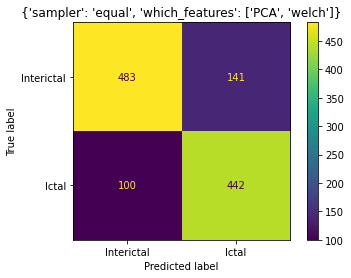

In [51]:
experiments = [             
               #{'sampler':'equal'},
               {'sampler':'equal', 'which_features':'welch']},
              ]

m = [KMeans(n_clusters=2), XGBClassifier(objective='binary:hinge', learning_rate = 0.01), KNeighborsClassifier()]
s = [False, True, True]
#m = [KNeighborsClassifier()]
#s = [True]

for i,model in enumerate(m):
    for kwords in experiments:
        t = ModelTrainer(model,s[i])
        t.train_all(kwords)
        t.summarize()

In [47]:
train = ChbDataset(mode='all',subject='chb10', sliding=False, which_features=['welch','PCA'], sampler='equal', multiclass=False,window_length=5)
ad = train.all_data()
train2 = ChbDataset(mode='all',subject='chb21',sliding=False, which_features=['welch'], sampler='equal', multiclass=False,window_length=5)
ad2 = train2.all_data()

['chb10/chb10_12.edf', 'chb10/chb10_20.edf', 'chb10/chb10_27.edf', 'chb10/chb10_30.edf', 'chb10/chb10_31.edf', 'chb10/chb10_38.edf', 'chb10/chb10_89.edf']
['chb21/chb21_19.edf', 'chb21/chb21_20.edf', 'chb21/chb21_21.edf', 'chb21/chb21_22.edf']


(174, 46)


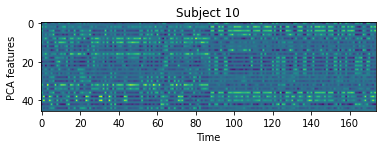

In [48]:
plt.imshow(ad[0].T)
plt.title('Subject 10')
plt.xlabel('Time')
plt.ylabel('PCA features')
print(ad[0].shape)

(78, 92)


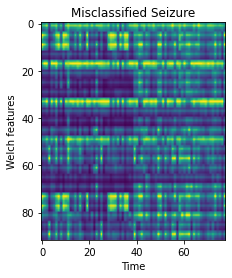

In [28]:
plt.imshow(ad2[0].T)
plt.title('Misclassified Seizure')
plt.xlabel('Time')
plt.ylabel('Welch features')
print(ad2[0].shape)

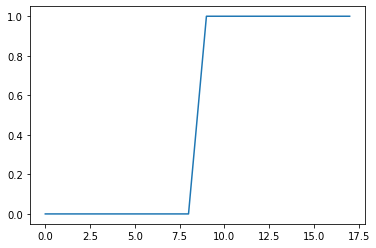

In [9]:
plt.plot(ad[1].T)
